# NLLS fitting with LMFIT

Lmfit provides a high-level interface to non-linear optimization and curve fitting problems for Python.
There are three main things that one needs in order to perform NLLS fitting succesfully in Python.
1. Data
2. Model
3. Initial values for parameters in the model

The image below summarizes how NLLS fitting works with these 3 entities.

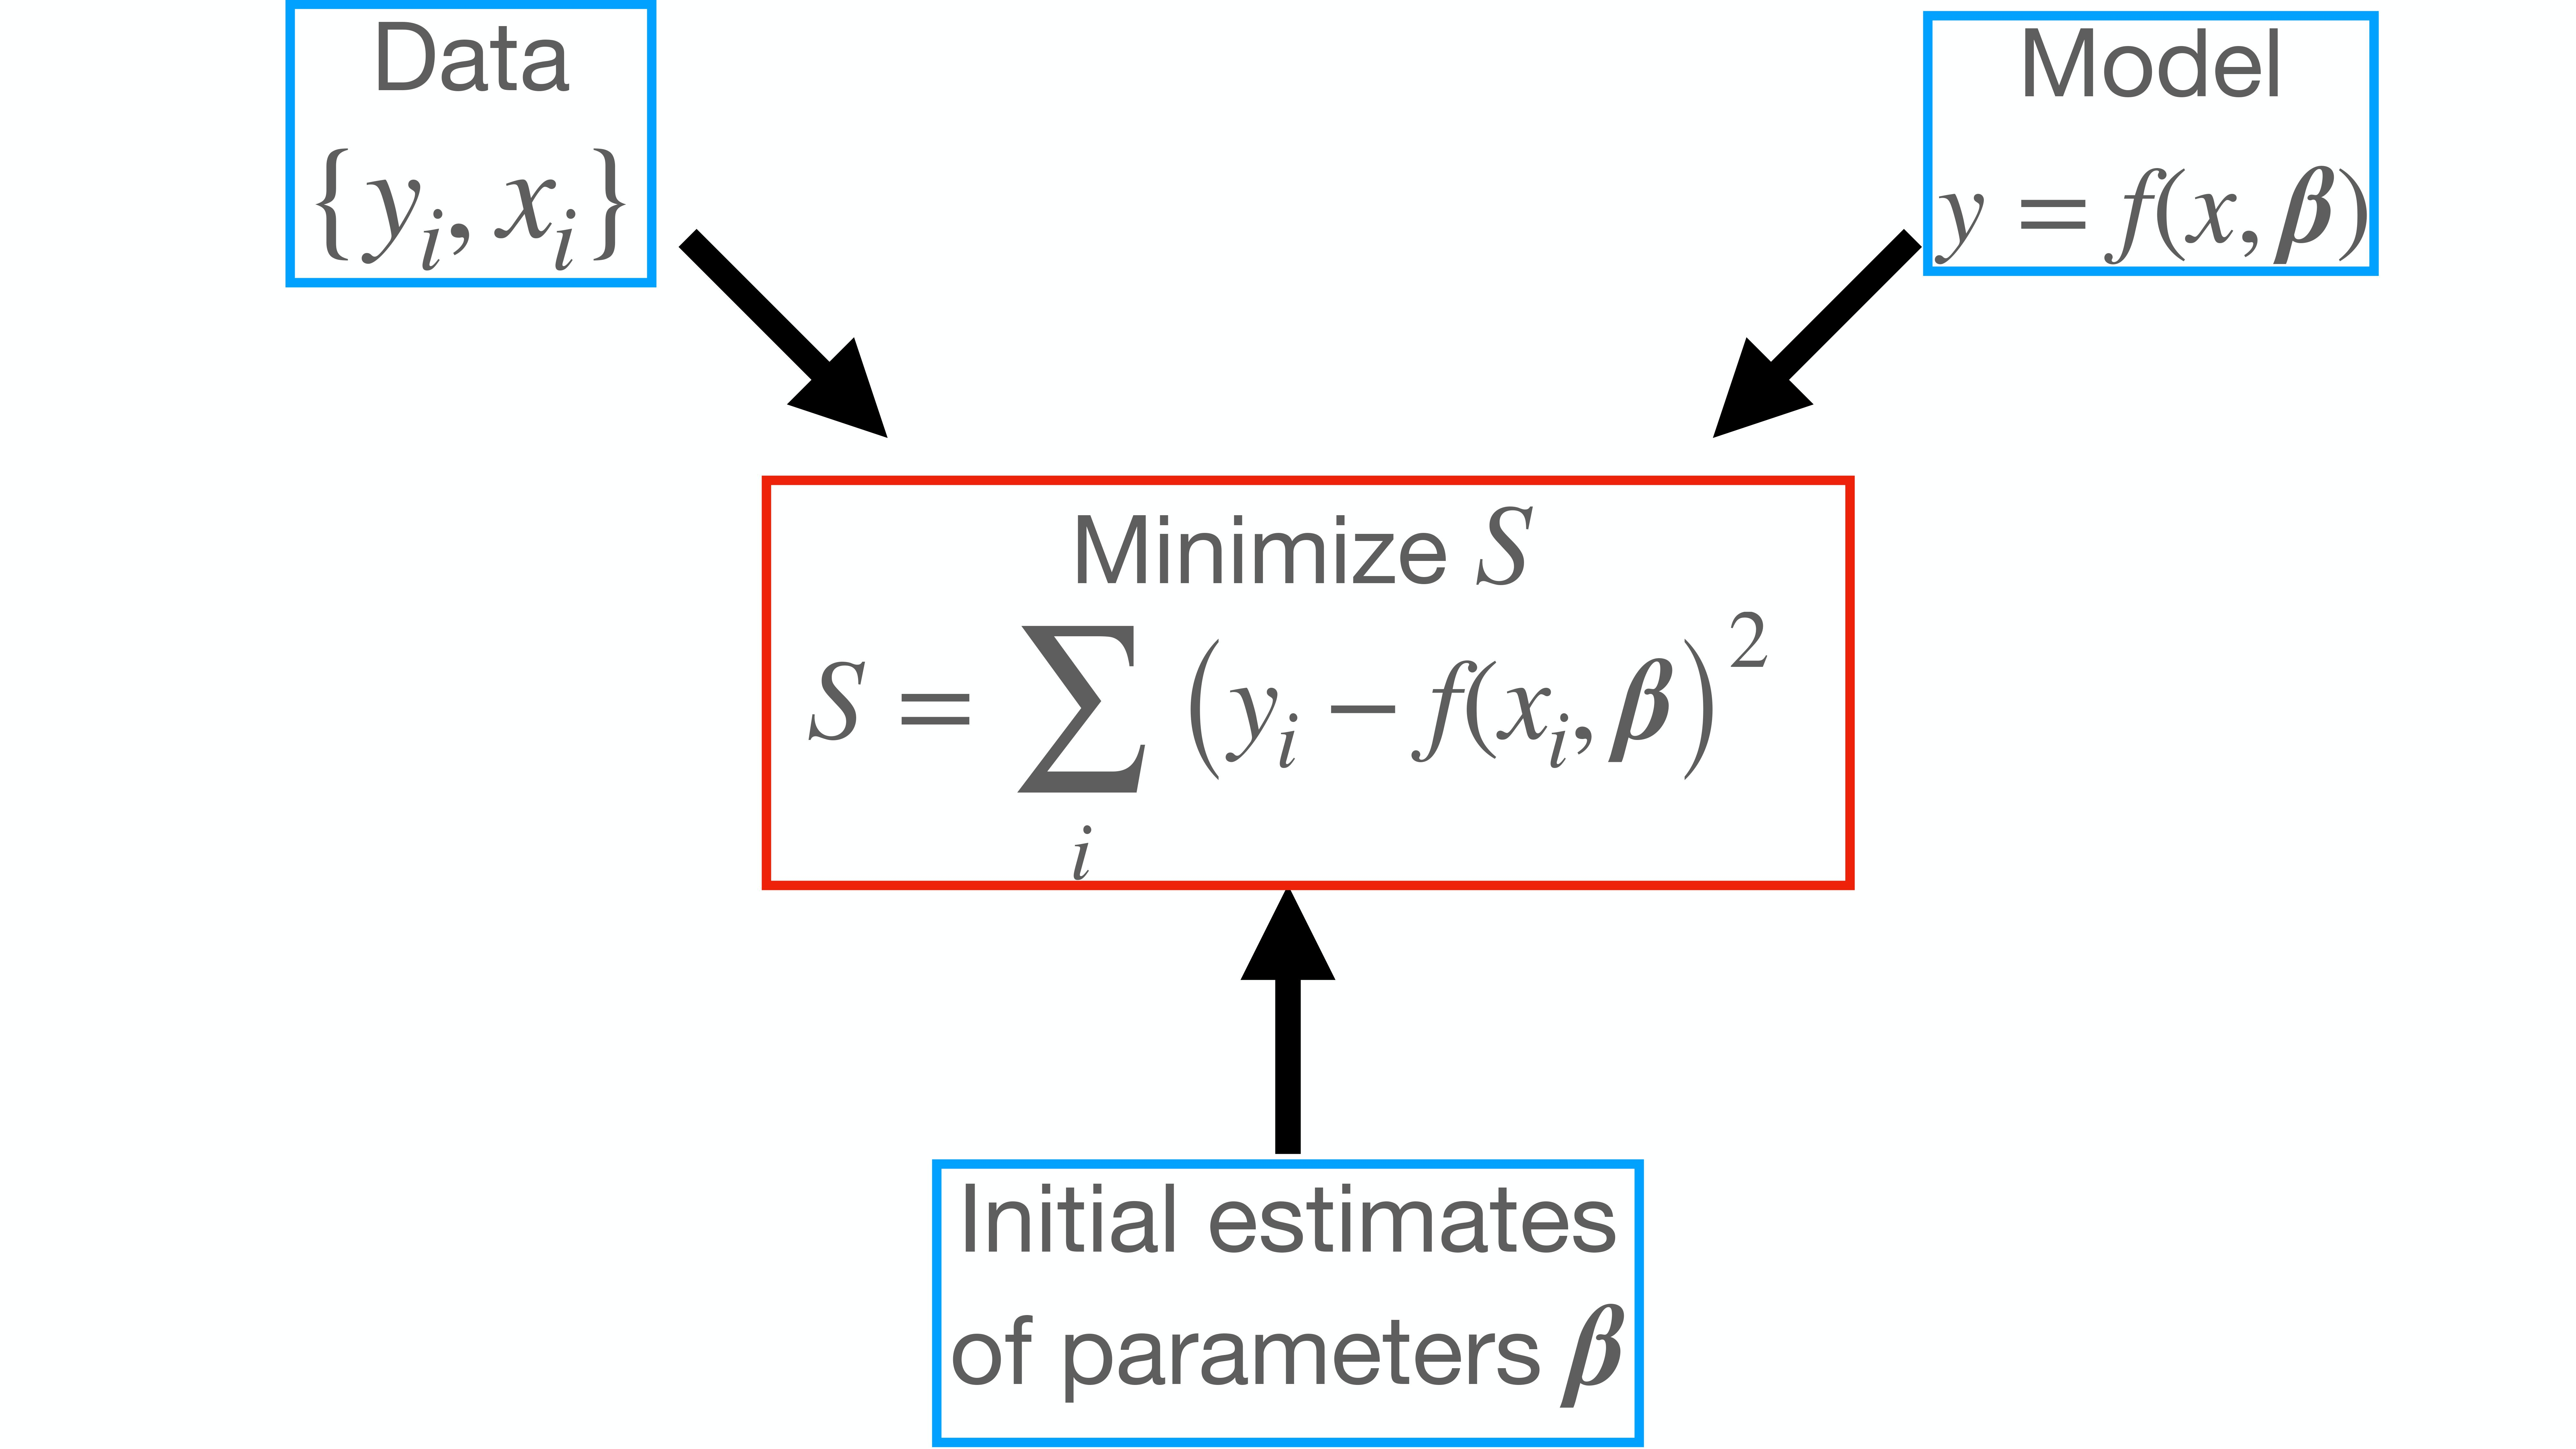

In [1]:
#Import necessary packages
from lmfit import Minimizer, Parameters, report_fit
import numpy as np
import matplotlib.pylab as plt

In [2]:
#Create artificial data
t = np.arange(0, 24, 2)
N = np.array([32500, 33000, 38000, 105000, 445000, 1430000, 3020000, 4720000, 5670000, 5870000, 5930000, 5940000])

In [3]:
#Set random seed for reproducibility
np.random.seed(1234)
#Add some error to data
N_rand = N*(1 + np.random.normal(scale = 0.1, size = len(N)))
#Plot

## Linear model fit

Lets start with the simplest case; a linear model. 

\begin{equation*}\label{eq:linear_model}
    N_t = at^3 + bt^2 + ct + d
\end{equation*} 

where $a$, $b$, $c$ and $d$, are phenomenological parameters.

In [4]:
#Create object for parameter storing
params_linear = Parameters()
#Add parameters and initial values
params_linear.add('a', value = 1)
params_linear.add('b', value = 1)
params_linear.add('c', value = 1)
params_linear.add('d', value = 1)

In [5]:
#Write down the objective function that we want to minimize, i.e., the residuals 
def residuals_linear(params, t, data):
    '''Model a logistic growth and subtract data'''
    #Get an ordered dictionary of parameter values
    v = params.valuesdict()
    #Logistic model
    model = v['a']*t**3 + v['b']*t**2 + v['c']*t + v['d']
    #Return residuals
    return model - data

In [6]:
#Create a Minimizer object
minner = Minimizer(residuals_linear, params_linear, fcn_args=(t, np.log(N_rand)))
#Perform the minimization
fit_linear = minner.minimize()

The variable `fit_linear` belongs to a class called [`MinimizerResult`](https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.MinimizerResult), which include data such as status and error messages, fit statistics, and the updated (i.e., best-fit) parameters themselves in the params attribute. 

In [7]:
#Get summary of the fit
report_fit(fit_linear)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 12
    # variables        = 4
    chi-square         = 1.68617886
    reduced chi-square = 0.21077236
    Akaike info crit   = -15.5493005
    Bayesian info crit = -13.6096739
[[Variables]]
    a: -0.00147820 +/- 5.3322e-04 (36.07%) (init = 1)
    b:  0.03687009 +/- 0.01787451 (48.48%) (init = 1)
    c:  0.14339899 +/- 0.16467922 (114.84%) (init = 1)
    d:  10.0545124 +/- 0.39977042 (3.98%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -0.984
    C(b, c) = -0.960
    C(a, c) =  0.900
    C(c, d) = -0.779
    C(b, d) =  0.621
    C(a, d) = -0.528


Note that `LMFIT`'s purpose is not to fit linear models, although it is general enough to do so. Fitting a 3rd degree polynomial can easily be done with the function `polyfit`, which performs the least squares polynomial fit. Next, I show that in the case of a linear model, both methods are equivalent.

In [8]:
#Fitting same data using polyfit
degree = 3
weights = np.polyfit(t, np.log(N_rand), degree) 
#Get parameter values obtained with LMFIT
par_dict = fit_linear.params.valuesdict().values()
#Transform into arr
par = np.array(list(par_dict))
#Check that they are the same as the parameters obtained with polyfit
diff = weights - par
print(diff) #Note that the difference is close to 0 because both methods are equivalent.

[ 2.18245647e-12  2.18892265e-12  7.72548692e-13 -1.61293201e-11]


In [9]:
#The minimized residuals of the fit can be calculated as the difference predicted - data
#Construct the fitted polynomial
poly = np.poly1d(weights)
#Computed predicted values
ypred = poly(t)
#Calculate residuals
residuals = ypred - np.log(N_rand)
#The residuals can be then used to calculate BIC, AIC, etc...

## Logistic model fit

A classical, somewhat mechanistic model is the logistic equation:

\begin{equation*}
    N_t =   \frac{N_0  N_{max} e^{r t}}{N_{max} + N_0 (e^{r t} - 1)}
\end{equation*}

Here $N_t$ is population size at time $t$, $N_0$ is initial population size, $r$ is maximum growth rate (AKA $r_{max}$), and $N_{max}$ is carrying capacity (commonly denoted by $K$ in the ecological literature).

In [10]:
#Create object for parameter storing
params_logistic = Parameters()
params_logistic.add('N_0', value = N_rand[0])
params_logistic.add('N_max', value = N_rand[-1])
#Recall the value for growth rate obtained from a linear fit
params_logistic.add('r', value = 0.62)

In [11]:
#Write down the objective function that we want to minimize, i.e., the residuals 
def residuals_logistic(params, t, data):
    '''Model a logistic growth and subtract data'''
    #Get an ordered dictionary of parameter values
    v = params.valuesdict()
    #Logistic model
    model = np.log(v['N_0'] * v['N_max'] * np.exp(v['r']*t) / \
    (v['N_max'] + v['N_0'] * ( np.exp(v['r']*t) - 1 )))
    #Return residuals
    return model - data

In [12]:
#Create a Minimizer object
minner = Minimizer(residuals_logistic, params_logistic, fcn_args=(t, np.log(N_rand)))
#Perform the minimization
fit_logistic = minner.minimize(method = 'leastsq')

Note that I am choosing the least squares as the optimization method. A table with alternative fitting algorithms offered by lmfit can be found [here](https://lmfit.github.io/lmfit-py/fitting.html#choosing-different-fitting-methods).

In [13]:
#Get summary of the fit
report_fit(fit_logistic)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 12
    # variables        = 3
    chi-square         = 2.19693074
    reduced chi-square = 0.24410342
    Akaike info crit   = -14.3741446
    Bayesian info crit = -12.9194246
[[Variables]]
    N_0:    13998.5739 +/- 4769.60185 (34.07%) (init = 34032.16)
    N_max:  7108406.32 +/- 2165947.53 (30.47%) (init = 6529216)
    r:      0.44848151 +/- 0.05161938 (11.51%) (init = 0.62)
[[Correlations]] (unreported correlations are < 0.100)
    C(N_0, r)     = -0.807
    C(N_max, r)   = -0.448
    C(N_0, N_max) =  0.239


Where function evals, is the number of iterations needed to reach the minimum. The `report_fit` function also offers estimations of goodness of fit such as $\chi^2$, BIC and AIC. These are calculated as specified [here](https://lmfit.github.io/lmfit-py/fitting.html#akaike-and-bayesian-information-criteria). Finally, uncertainties of each parameter estimate, correlation levels between them are also calculated. Details and caveats about these values can be found [here](https://lmfit.github.io/lmfit-py/fitting.html#uncertainties-in-variable-parameters-and-their-correlations).

## Gompertz model fit

Another alternative is the Gompertz model, which has been used frequently in the literature to model bacterial growth

\begin{equation*}\label{eq:Gompertzlog}
     \log(N_t) =  N_0 + (N_{max} - N_0) e^{-e^{r_{max} \exp(1) \frac{t_{lag} - t}{(N_{max} - N_0) \log(10)} + 1}}
\end{equation*}

Here maximum growth rate ($r_{max}$) is the tangent to the inflection point, $t_{lag}$ is the x-axis intercept to this tangent (duration of the delay before the population starts growing exponentially) and $\log\left(\frac{N_{max}}{N_0}\right)$ is the asymptote of the log-transformed population growth trajectory, i.e., the log ratio of maximum population density $N_{max}$ (aka “carrying capacity”) and initial cell (Population) $N_0$ density.

In [14]:
#Create object for parameter storing
params_gompertz = Parameters()
# add with tuples: (NAME VALUE VARY MIN  MAX  EXPR  BRUTE_STEP)
params_gompertz.add_many(('N_0', np.log(N_rand)[0] , True, 0, None, None, None),
                         ('N_max', np.log(N_rand)[-1], True, 0, None, None, None),
                         ('r_max', 0.62, True, None, None, None, None),
                         ('t_lag', 5, True, 0, None, None, None))#I see it in the graph


In [15]:
#Write down the objective function that we want to minimize, i.e., the residuals 
def residuals_gompertz(params, t, data):
    '''Model a logistic growth and subtract data'''
    #Get an ordered dictionary of parameter values
    v = params.valuesdict()
    #Logistic model
    model = v['N_0'] + (v['N_max'] - v['N_0']) * \
    np.exp(-np.exp(v['r_max'] * np.exp(1) * (v['t_lag'] - t) / \
                   ((v['N_max'] - v['N_0']) * np.log(10)) + 1))
    #Return residuals
    return model - data

In [16]:
#Create a Minimizer object
minner = Minimizer(residuals_gompertz, params_gompertz, fcn_args=(t, np.log(N_rand)))
#Perform the minimization
fit_gompertz = minner.minimize()

In [17]:
#Sumarize results
report_fit(fit_gompertz)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 12
    # variables        = 4
    chi-square         = 0.11350314
    reduced chi-square = 0.01418789
    Akaike info crit   = -47.9299775
    Bayesian info crit = -45.9903509
[[Variables]]
    N_0:    10.3910132 +/- 0.07901002 (0.76%) (init = 10.43506)
    N_max:  15.6520240 +/- 0.06730933 (0.43%) (init = 15.6918)
    r_max:  1.74097660 +/- 0.09837840 (5.65%) (init = 0.62)
    t_lag:  4.52049075 +/- 0.24729695 (5.47%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_max, t_lag) =  0.757
    C(N_0, t_lag)   =  0.581
    C(N_max, r_max) = -0.465
    C(N_max, t_lag) = -0.318
    C(N_0, N_max)   = -0.132
    C(N_0, r_max)   =  0.115


## Plot results

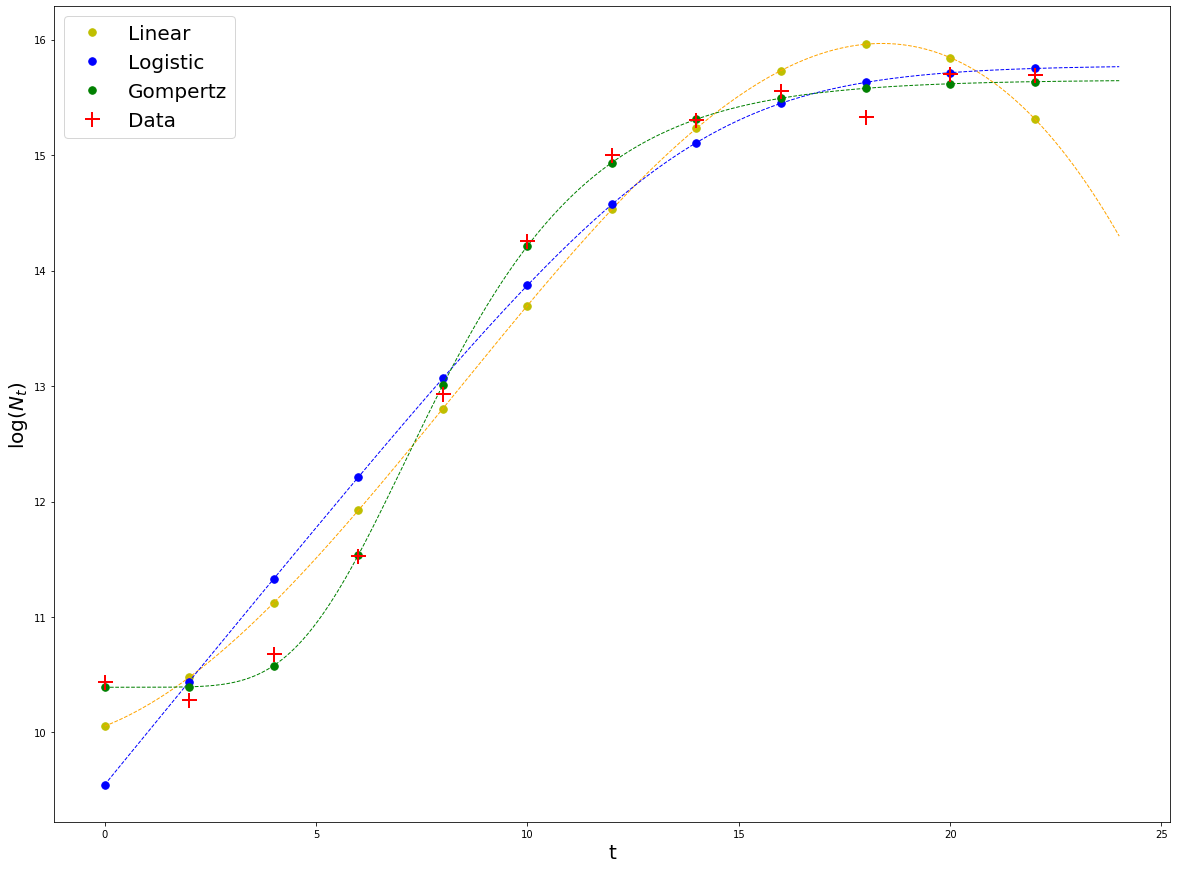

In [18]:
plt.rcParams['figure.figsize'] = [20, 15]
#Linear
result_linear = np.log(N_rand) + fit_linear.residual
plt.plot(t, result_linear, 'y.', markersize = 15, label = 'Linear')
#Get a smooth curve by plugging a time vector to the fitted logistic model
t_vec = np.linspace(0,24,1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_linear = residuals_linear(fit_linear.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_linear + log_N_vec, 'orange', linestyle = '--', linewidth = 1)

#Logistic
result_logistic = np.log(N_rand) + fit_logistic.residual
plt.plot(t, result_logistic, 'b.', markersize = 15, label = 'Logistic')
#Get a smooth curve by plugging a time vector to the fitted logistic model
t_vec = np.linspace(0,24,1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_logistic = residuals_logistic(fit_logistic.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_logistic + log_N_vec, 'blue', linestyle = '--', linewidth = 1)

#Gompertz
result_gompertz = np.log(N_rand) + fit_gompertz.residual
plt.plot(t, result_gompertz, 'g.', markersize = 15, label = 'Gompertz')
#Get a smooth curve by plugging a time vector to the fitted logistic model
t_vec = np.linspace(0,24,1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_gompertz = residuals_gompertz(fit_gompertz.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_gompertz + log_N_vec, 'green', linestyle = '--', linewidth = 1)

#Plot data points
plt.plot(t, np.log(N_rand), 'r+', markersize = 15,markeredgewidth = 2, label = 'Data')

#Plot legend
plt.legend(fontsize = 20)
plt.xlabel('t', fontsize = 20)
plt.ylabel(r'$\log(N_t)$', fontsize = 20)
plt.ticklabel_format(style='scientific', scilimits=[0,3])

## Exercise

The generalized Logistic model (also known as Richards' curve) is an extension of the logistic or sigmoid functions, allowing for more flexible S-shaped curves:

\begin{equation*}\label{eq:Hill}
    \log(N_t) = A + \frac{K - A}{1 + Q(e^{-Bt})^{1/\mu}}
\end{equation*}

Where $A$ is the lower asymptote, $K$ is the higher asymptote. If $A=0$ then $K$ is the carrying capacity. $B$ is the growth rate, $\mu >0$ affects near which asymptote maximum growth occurs. $Q$ is related to the value $N(0)$

Fit this model to the data using as initial values for the parameters: $A = 10$, $K = 16$, $Q = 0.5$, $B = 1$, $\mu = 0.1$, $T = 7.5$

In [19]:
#Define the parameter object
params_genlogistic = Parameters()
#Add parameters and initial values
params_genlogistic.add('A', value = 10, min = 0)
params_genlogistic.add('K', value = 16, min = 0)
params_genlogistic.add('Q', value = 0.5, min = 0)
params_genlogistic.add('B', value = 1, min = 0)
params_genlogistic.add('mu', value = 0.1, min = 0)
params_genlogistic.add('T', value = 7.5, min = 0)

In [20]:
#Define the model
def residuals_genlogistic(params, t, data):
    '''Model a logistic growth and subtract data'''
    #Get an ordered dictionary of parameter values
    v = params.valuesdict()
    #Logistic model
    model = v['A'] + (v['K'] - v['A']) / \
    (1 + v['Q'] * np.exp(-v['B']*(t-v['T'])))**(1/v['mu'])
    #Return residuals
    return model - data

In [21]:
#Perform the fit
#Create a Minimizer object
minner = Minimizer(residuals_genlogistic, params_genlogistic, fcn_args=(t, np.log(N_rand)))
#Perform the minimization
fit_genlogistic = minner.minimize()

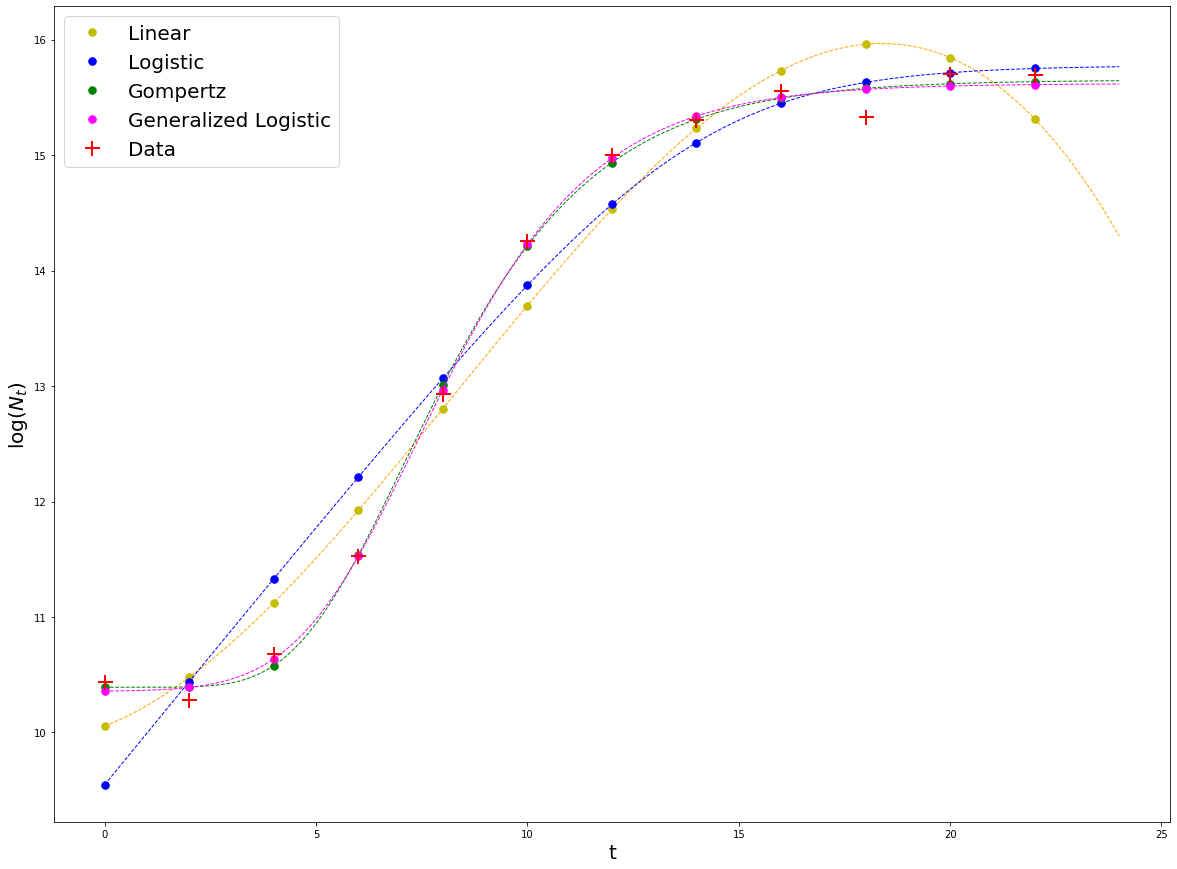

In [22]:
#Overlay the fit with the others

plt.rcParams['figure.figsize'] = [20, 15]
#Linear
result_linear = np.log(N_rand) + fit_linear.residual
plt.plot(t, result_linear, 'y.', markersize = 15, label = 'Linear')
#Get a smooth curve by plugging a time vector to the fitted logistic model
t_vec = np.linspace(0,24,1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_linear = residuals_linear(fit_linear.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_linear + log_N_vec, 'orange', linestyle = '--', linewidth = 1)

#Logistic
result_logistic = np.log(N_rand) + fit_logistic.residual
plt.plot(t, result_logistic, 'b.', markersize = 15, label = 'Logistic')
#Get a smooth curve by plugging a time vector to the fitted logistic model
t_vec = np.linspace(0,24,1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_logistic = residuals_logistic(fit_logistic.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_logistic + log_N_vec, 'blue', linestyle = '--', linewidth = 1)

#Gompertz
result_gompertz = np.log(N_rand) + fit_gompertz.residual
plt.plot(t, result_gompertz, 'g.', markersize = 15, label = 'Gompertz')
#Get a smooth curve by plugging a time vector to the fitted logistic model
t_vec = np.linspace(0,24,1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_gompertz = residuals_gompertz(fit_gompertz.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_gompertz + log_N_vec, 'green', linestyle = '--', linewidth = 1)

#Generalized logistic
result_genlogistic = np.log(N_rand) + fit_genlogistic.residual
plt.plot(t, result_genlogistic, '.', markerfacecolor = 'magenta', 
         markeredgecolor = 'magenta', markersize = 15, label = 'Generalized Logistic')
#Get a smooth curve by plugging a time vector to the fitted logistic model
t_vec = np.linspace(0,24,1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_genlogistic = residuals_genlogistic(fit_genlogistic.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_genlogistic + log_N_vec, 'magenta', linestyle = '--', linewidth = 1)

#Plot data points
plt.plot(t, np.log(N_rand), 'r+', markersize = 15,markeredgewidth = 2, label = 'Data')

#Plot legend
plt.legend(fontsize = 20)
plt.xlabel('t', fontsize = 20)
plt.ylabel(r'$\log(N_t)$', fontsize = 20)
plt.ticklabel_format(style='scientific', scilimits=[0,3])

We can visually tell that the model that best fits the data is the Generalized Logistic model, closely followed by the Gompertz model. Does this mean that the Generalized Logistic model is a better model?

No. Generally, better models will be those that fit the data well, have less parameters, and these can be interpreted mechanistically. In these case, the Gomperz model fits the data almost as good as the Generalized Logistic (GL), but has less parameters, and these are more 'mechanistic' than the ones in GL, so it is clearly better.